### Bank Traffic | EDA and  Regression Model

**This notebook explains how we can go about explore and prepare data for model building.**

*The notebook is structured in the following way:*

- About Dataset.
    - Covid Datasets
    - Bank Traffic Datasets
- Data Summary.
- Feature Engineering.
- EDA
- Model:
    - CatBoost Model.
    - XGBoost Model.
    - Grediant Boost Model.

###  Data Feature

- **Timestamp** : datetime(year-month-day Hour:minute:second).
- **Count** : number of customer for every window by day.
- **Window** : number of window services

**Import needed Liberaries**

In [1]:
# important lib.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and metrics 
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# regression models
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor 
import xgboost as xgb

import missingno as msno
import warnings

In [2]:
warnings.filterwarnings('ignore')

### About Dataset

## Covid Data

In [3]:
# we use to covid dataset from kaggle that dataset have true values for all country on the world.

# read covid datasets.
covid_df = pd.read_csv('data/countries-aggregated.csv')
covid_df.head()

,Date,Country,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,0,0,0
1,2020-01-23,Afghanistan,0,0,0
2,2020-01-24,Afghanistan,0,0,0
3,2020-01-25,Afghanistan,0,0,0
4,2020-01-26,Afghanistan,0,0,0


In [4]:
# select Egypt dataset from covid data.
covid_df = covid_df[covid_df['Country']=='Egypt']
covid_df.head()

,Date,Country,Confirmed,Recovered,Deaths
33867,2020-01-22,Egypt,0,0,0
33868,2020-01-23,Egypt,0,0,0
33869,2020-01-24,Egypt,0,0,0
33870,2020-01-25,Egypt,0,0,0
33871,2020-01-26,Egypt,0,0,0


In [5]:
# drop country column from data because it has one value 'Egypt' and we don't need it.
covid_df.drop(['Country'], axis=1, inplace=True)

In [6]:
# set datetime type for Date to can handle easy.
covid_df.Date = pd.to_datetime(covid_df['Date'])
covid_df.dtypes

Date         datetime64[ns]
Confirmed             int64
Recovered             int64
Deaths                int64
dtype: object

In [7]:
# extract year, month, day values from date column.
covid_df['year'] = covid_df.Date.dt.year
covid_df['month'] = covid_df.Date.dt.month
covid_df['day'] = covid_df.Date.dt.day

In [8]:
# now we don't neet Date column, so we will drop it.
covid_df.drop(['Date'], axis=1, inplace=True)
covid_df.tail()

,Confirmed,Recovered,Deaths,year,month,day
34501,318456,0,17970,2021,10,17
34502,319339,0,18015,2021,10,18
34503,320207,0,18058,2021,10,19
34504,321084,0,18105,2021,10,20
34505,321967,0,18151,2021,10,21


In [9]:
# confirmed, recovered, deaths columns have cumulative values, so subtract every row from previous.
covid_df['Confirmed'] = covid_df['Confirmed'].diff()
covid_df['Recovered'] = covid_df['Recovered'].diff()
covid_df['Deaths'] = covid_df['Deaths'].diff()

In [10]:
# now covid dataset is ready.
covid_df.tail()

,Confirmed,Recovered,Deaths,year,month,day
34501,871.0,0.0,44.0,2021,10,17
34502,883.0,0.0,45.0,2021,10,18
34503,868.0,0.0,43.0,2021,10,19
34504,877.0,0.0,47.0,2021,10,20
34505,883.0,0.0,46.0,2021,10,21


## Bank Traffic Data

In [11]:
# read bank traffic dataset.
df = pd.read_csv('data/bank_traffic_data.csv')
df.tail()

,timestamp,count,window
10008,2021-07-27 02:00:00+02:00,173,15
10009,2021-07-28 02:00:00+02:00,117,15
10010,2021-07-29 02:00:00+02:00,137,15
10011,2021-07-30 02:00:00+02:00,0,15
10012,2021-07-31 02:00:00+02:00,0,15


In [12]:
# print columns types of data
df.dtypes

timestamp    object
count         int64
window        int64
dtype: object

In [13]:
# data summary
df.describe()

,count,window
count,10013.000000,10013.000000
mean,261.946669,8.020673
std,453.700521,4.334112
min,0.000000,1.000000
25%,0.000000,4.000000
50%,134.000000,8.000000
75%,211.000000,12.000000
max,4670.000000,15.000000


In [14]:
# more info about data, there is no null value in dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10013 entries, 0 to 10012
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10013 non-null  object
 1   count      10013 non-null  int64 
 2   window     10013 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.8+ KB


In [15]:
# print dimensionality of datsets
df.shape

(10013, 3)

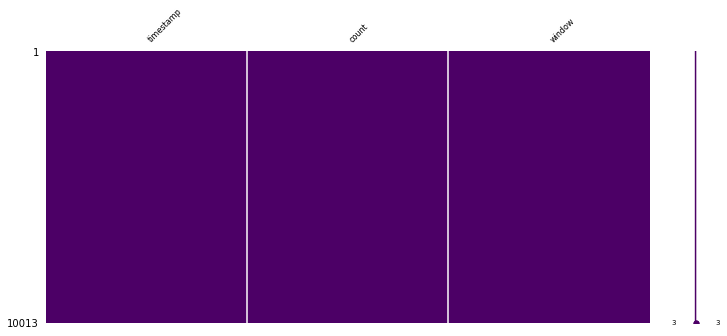

In [16]:
# check if there is any null values.
msno.matrix(df,figsize=(12,5),color=(0.3, 0.0, 0.4),fontsize=8)
plt.show()

In [17]:
# change timestamp column to datetime, we can use easy.
df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d %H:%M:%S")
df.dtypes

timestamp    datetime64[ns, pytz.FixedOffset(120)]
count                                        int64
window                                       int64
dtype: object

## Feature Engineering

In [18]:
# extract all datetime part (year, month, day, ....etc).
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['hour'] = df.timestamp.dt.hour
df['minute']  =df.timestamp.dt.minute
df['second'] = df.timestamp.dt.second
df['day_name'] = df.timestamp.dt.day_name()

**There is some days have official vacation and count is equal to zero**

In [19]:
df['official_vacation'] = 0
df.loc[(df['count']==0)& ((df['day_name']!='Friday')&(df['day_name']!='Saturday')), 'official_vacation'] = 1

In [20]:
df.head()

,timestamp,count,window,year,month,day,hour,minute,second,day_name,official_vacation
0,2019-09-26 02:00:00+02:00,764,1,2019,9,26,2,0,0,Thursday,0
1,2019-09-27 02:00:00+02:00,0,1,2019,9,27,2,0,0,Friday,0
2,2019-09-28 02:00:00+02:00,0,1,2019,9,28,2,0,0,Saturday,0
3,2019-09-29 02:00:00+02:00,1973,1,2019,9,29,2,0,0,Sunday,0
4,2019-09-30 02:00:00+02:00,1908,1,2019,9,30,2,0,0,Monday,0


## EDA

In [21]:
df['official_vacation'].value_counts()

0    9292
1     721
Name: official_vacation, dtype: int64

In [22]:
df[(df['official_vacation']==1)&(df['month'])==8]

,timestamp,count,window,year,month,day,hour,minute,second,day_name,official_vacation


**There is no official vaction holiday on August, this for test dataset**

In [23]:
# all window have same rows count on dataset.
df.window.value_counts().sort_index()

1     675
2     675
3     675
4     640
5     639
6     675
7     675
8     675
9     634
10    675
11    675
12    675
13    675
14    675
15    675
Name: window, dtype: int64

In [24]:
# hour have the same value in all dataset, so we will drop it
df.hour.value_counts()

2    10013
Name: hour, dtype: int64

In [25]:
# minute have the same value in all dataset, so we will drop it
df.minute.value_counts()

0    10013
Name: minute, dtype: int64

In [26]:
# second have the same value in all dataset, so we will drop it
df.second.value_counts()

0    10013
Name: second, dtype: int64

In [27]:
# we will use onehot encode for year column.
df.year.value_counts().sort_index()

2019    1455
2020    5490
2021    3068
Name: year, dtype: int64

**drop hour, minute, second columns**

In [28]:
# drop columns that have one value on all dataset.
df.drop(['hour', 'minute', 'second'], axis=1, inplace=True)

In [29]:
df.head()

,timestamp,count,window,year,month,day,day_name,official_vacation
0,2019-09-26 02:00:00+02:00,764,1,2019,9,26,Thursday,0
1,2019-09-27 02:00:00+02:00,0,1,2019,9,27,Friday,0
2,2019-09-28 02:00:00+02:00,0,1,2019,9,28,Saturday,0
3,2019-09-29 02:00:00+02:00,1973,1,2019,9,29,Sunday,0
4,2019-09-30 02:00:00+02:00,1908,1,2019,9,30,Monday,0


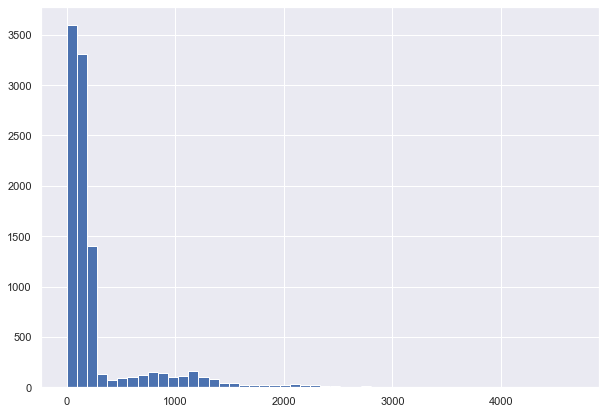

In [30]:
# distribution of count column.
sns.set()
plt.figure(figsize=(10,7))
plt.hist(df['count'],bins=50)
plt.show()

### aggregate on date

In [31]:
# aggregation day_name with count, we notic that friday and saturday are holiday.
agg_day_name = df.groupby('day_name')['count'].mean().sort_values()
agg_day_name

day_name
Friday         0.000000
Saturday       0.000000
Wednesday    320.365169
Thursday     325.698402
Sunday       374.934035
Monday       381.452949
Tuesday      435.759831
Name: count, dtype: float64

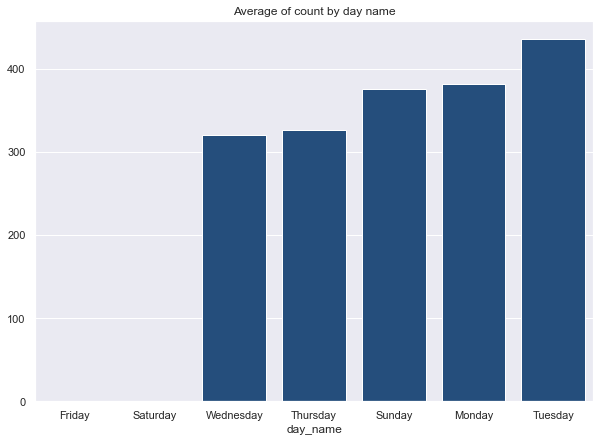

In [32]:
plt.figure(figsize=(10,7))
sns.barplot(x=agg_day_name.index, y=agg_day_name.values, color='#174d8a')
plt.title('Average of count by day name')
plt.show()

In [33]:
# aggregation day with count.
agg_day = df.groupby('day')['count'].mean().sort_values()
agg_day.head()

day
28    218.477876
12    223.241590
25    223.656442
19    224.452599
20    226.171254
Name: count, dtype: float64

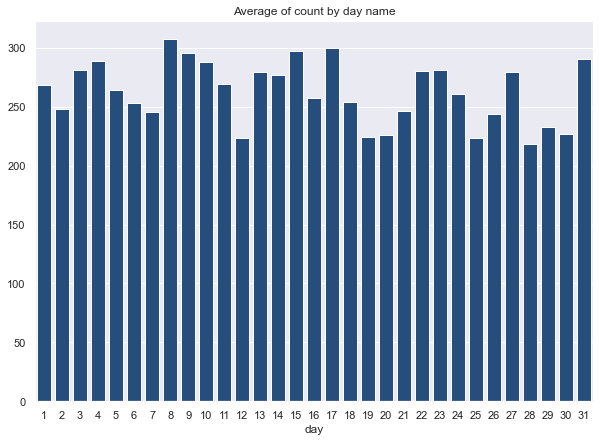

In [34]:
plt.figure(figsize=(10,7))
sns.barplot(x=agg_day.index, y=agg_day.values, color='#174d8a')
plt.title('Average of count by day name')
plt.show()

In [35]:
# aggregation day_name with count, we notic that 2020 have little average count.
agg_year = df.groupby('year')['count'].mean().sort_values()
agg_year.head()

year
2020    232.256831
2019    283.481100
2021    304.862125
Name: count, dtype: float64

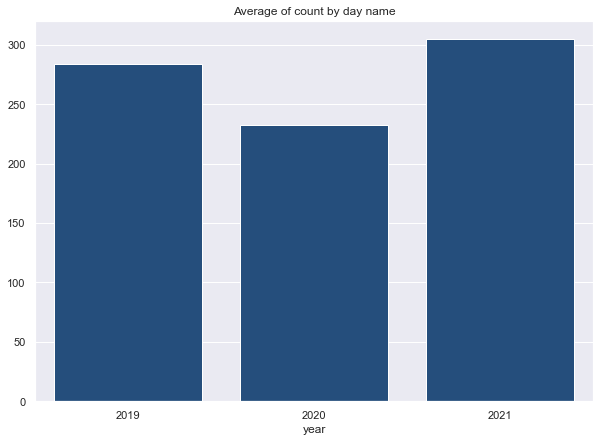

In [36]:
plt.figure(figsize=(10,7))
sns.barplot(x=agg_year.index, y=agg_year.values, color='#174d8a')
plt.title('Average of count by day name')
plt.show()

In [37]:
# aggregation month with count, we notic this december month has highest average of count.
agg_month = df.groupby('month')['count'].mean().sort_values()
agg_month.head()

month
5    178.508602
4    208.742222
8    232.948387
9    236.352381
7    237.869773
Name: count, dtype: float64

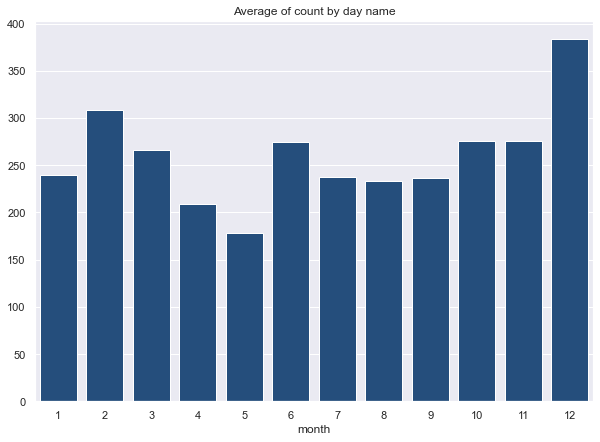

In [38]:
plt.figure(figsize=(10,7))
sns.barplot(x=agg_month.index, y=agg_month.values, color='#174d8a')
plt.title('Average of count by day name')
plt.show()

### Data Prepration

### Merge Data

In [39]:
# merge covid dataset with bank traffic dataset, based on year, month and day columns.
df = df.merge(covid_df, how='left', on=['year','month','day'])
df.tail()

,timestamp,count,window,year,month,day,day_name,official_vacation,Confirmed,Recovered,Deaths
10008,2021-07-27 02:00:00+02:00,173,15,2021,7,27,Tuesday,0,31.0,654.0,4.0
10009,2021-07-28 02:00:00+02:00,117,15,2021,7,28,Wednesday,0,38.0,212.0,9.0
10010,2021-07-29 02:00:00+02:00,137,15,2021,7,29,Thursday,0,42.0,331.0,7.0
10011,2021-07-30 02:00:00+02:00,0,15,2021,7,30,Friday,0,45.0,545.0,4.0
10012,2021-07-31 02:00:00+02:00,0,15,2021,7,31,Saturday,0,47.0,656.0,6.0


In [40]:
# null values before corona comming, so we will fill nan values by zero.
df.isnull().sum()

timestamp               0
count                   0
window                  0
year                    0
month                   0
day                     0
day_name                0
official_vacation       0
Confirmed            1785
Recovered            1785
Deaths               1785
dtype: int64

In [41]:
# sure that merged data has same dimension of bank traffic data.
df.shape

(10013, 11)

In [42]:
# fill nan values by zero.
df.fillna(0,inplace=True)

In [43]:
# replace recovered mius values by zero.
df.loc[df.Recovered<0, "Recovered"] = 0

In [44]:
# onehotencode for year and day_name columns.
df = pd.concat([df, pd.get_dummies(df['year'], prefix="year")], axis=1)
# df = pd.concat([df, pd.get_dummies(df['month'], prefix="month")], axis=1)
df = pd.concat([df, pd.get_dummies(df['day_name'])], axis=1)
df.head()

,timestamp,count,window,year,month,day,day_name,official_vacation,Confirmed,Recovered,...,year_2019,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,2019-09-26 02:00:00+02:00,764,1,2019,9,26,Thursday,0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
1,2019-09-27 02:00:00+02:00,0,1,2019,9,27,Friday,0,0.0,0.0,...,1,0,0,1,0,0,0,0,0,0
2,2019-09-28 02:00:00+02:00,0,1,2019,9,28,Saturday,0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,0
3,2019-09-29 02:00:00+02:00,1973,1,2019,9,29,Sunday,0,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
4,2019-09-30 02:00:00+02:00,1908,1,2019,9,30,Monday,0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0


In [45]:
# pop count column and add it at end of data, that is the target column.
columns = df.columns.tolist()
columns.append(columns.pop(1))
df = df[columns]
df.head()

,timestamp,window,year,month,day,day_name,official_vacation,Confirmed,Recovered,Deaths,...,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,count
0,2019-09-26 02:00:00+02:00,1,2019,9,26,Thursday,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,764
1,2019-09-27 02:00:00+02:00,1,2019,9,27,Friday,0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,2019-09-28 02:00:00+02:00,1,2019,9,28,Saturday,0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,2019-09-29 02:00:00+02:00,1,2019,9,29,Sunday,0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1973
4,2019-09-30 02:00:00+02:00,1,2019,9,30,Monday,0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1908


In [46]:
# drop not needed columns.
df_new = df.drop(['timestamp', 'year', 'day_name', "Recovered"], axis=1)
df_new.head()

,window,month,day,official_vacation,Confirmed,Deaths,year_2019,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,count
0,1,9,26,0,0.0,0.0,1,0,0,0,0,0,0,1,0,0,764
1,1,9,27,0,0.0,0.0,1,0,0,1,0,0,0,0,0,0,0
2,1,9,28,0,0.0,0.0,1,0,0,0,0,1,0,0,0,0,0
3,1,9,29,0,0.0,0.0,1,0,0,0,0,0,1,0,0,0,1973
4,1,9,30,0,0.0,0.0,1,0,0,0,1,0,0,0,0,0,1908


In [47]:
# calculate correlation matrix with target column..
corrMatt = df_new.corr()
corrMatt.loc[:,'count'].sort_values()

Friday              -0.236540
Saturday            -0.236444
window              -0.220977
official_vacation   -0.160834
year_2020           -0.072100
day                 -0.020890
Confirmed            0.002650
year_2019            0.019572
Deaths               0.020023
month                0.050109
Wednesday            0.052431
Thursday             0.057568
year_2021            0.062872
Sunday               0.101448
Monday               0.107257
Tuesday              0.155998
count                1.000000
Name: count, dtype: float64

## Data Split

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(df_new.drop(['count'], axis=1),
                                                      df_new['count'],
                                                      test_size=0.2,
                                                      random_state=42)

print("X_train Shape = ", X_train.shape)
print("="*30)
print("X_valid Shape = ", X_valid.shape)

X_train Shape =  (8010, 16)
X_valid Shape =  (2003, 16)


## Train Model

### GBoost

In [49]:
params = {'n_estimators': 1000,
          'max_depth': 5,
          'random_state': 0,
          'min_samples_leaf': 6,
          'learning_rate': 0.05,
          'subsample': 0.75,
          'loss': 'ls'}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)
val_pred = mean_absolute_error(y_train, reg.predict(X_train))
print("Mean Absolute Error Validation ====> ", val_pred)
val_pred = mean_absolute_error(y_valid, reg.predict(X_valid))
print("Mean Absolute Error Validation ====> ", val_pred)

Mean Absolute Error Validation ====>  31.51252683867413
Mean Absolute Error Validation ====>  53.318537509120794


### CatBoost

In [50]:
catBoost = CatBoostRegressor(objective='Poisson',
                             n_estimators=2000,
                             random_state=0,
                             learning_rate=0.05,
                             subsample=0.75,
                             max_depth=5,
                             verbose=0)

catBoost.fit(X_train,y_train)

y_pred = [int(i) for i in catBoost.predict(X_train)]

rmse_train = mean_absolute_error(y_train, y_pred)
rmse_val = mean_absolute_error(y_valid, catBoost.predict(X_valid))

print("Mean Absolute Error Trian ====> ",round(rmse_train,6))
print('='*30)
print("RMSE Validation ====> ",round(rmse_val,6))

Mean Absolute Error Trian ====>  17.398876
RMSE Validation ====>  32.183852


R-squared for train data 0.9933356493119043
R-squared for valid data 0.9541432516126209


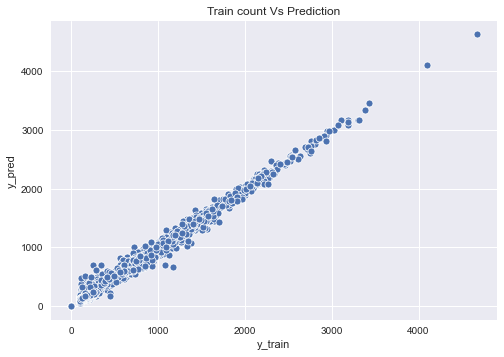

In [51]:
plt.style.use('seaborn')
y_pred = [int(i) for i in catBoost.predict(X_train)]
print("R-squared for train data",catBoost.score(X_train, y_train))
print("="*50)
print("R-squared for valid data",catBoost.score(X_valid, y_valid))
sns.scatterplot(y_train, y_pred)
plt.title('Train count Vs Prediction')
plt.xlabel("y_train")
plt.ylabel("y_pred")
plt.show()

### XGBoost

In [52]:
xg_reg = xgb.XGBRegressor(objective="count:poisson",
                          random_state=0,
                          colsample_bytree = 0.6, 
                          learning_rate = 0.05,
                          gamma = 8,
                          n_estimators = 2000,
                          max_depth=5 ,
                          subsample=0.75,
                          min_child_weight=5)

xg_reg = xg_reg.fit(X_train,y_train)

rmse_train = mean_absolute_error(y_train, [int(x) for  x in xg_reg.predict(X_train)])
rmse_val = mean_absolute_error(y_valid, [int(x) for x in xg_reg.predict(X_valid)])

print("Mean Absolute Error Train =====> %f" % (round(rmse_train,6)))
print('='*30)
print("Mean Absolute Error Validation ====> %f"%(round(rmse_val,6)))

Mean Absolute Error Train =====> 19.155181
Mean Absolute Error Validation ====> 31.763854


In [53]:
rmse_train = np.sqrt(mean_squared_log_error(y_train,  xg_reg.predict(X_train)))
rmse_val = np.sqrt(mean_squared_log_error(y_valid, xg_reg.predict(X_valid)))

print("RMSLE Trian ====> ",round(rmse_train,6))
print('='*30)
print("RMSLE Validation ====> ",round(rmse_val,6))

RMSLE Trian ====>  0.115209
RMSLE Validation ====>  0.159041


R-squared for train data 0.9918097891258069
R-squared for valid data 0.954605301372484


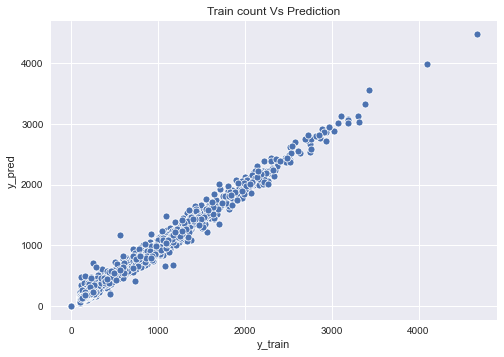

In [54]:
plt.style.use('seaborn')
y_pred = [int(i) for i in xg_reg.predict(X_train)]
print("R-squared for train data",xg_reg.score(X_train, y_train))
print("="*50)
print("R-squared for valid data",xg_reg.score(X_valid, y_valid))
sns.scatterplot(y_train, y_pred)
plt.title('Train count Vs Prediction')
plt.xlabel("y_train")
plt.ylabel("y_pred")
plt.show()

## Testing Model

In [55]:
# creat test data it is star from (1/8/2021) to (31/8/2021)
df_test = df[(df.year==2020)&(df.month==8)][["timestamp", "window", "year", "month", "day"]]
df_test.year = 2021
df_test.timestamp = df_test.timestamp.apply(lambda dt: dt.replace(year=2021))
df_test['day_name'] = df_test.timestamp.dt.day_name()
df_test.head()

,timestamp,window,year,month,day,day_name
310,2021-08-01 02:00:00+02:00,1,2021,8,1,Sunday
311,2021-08-02 02:00:00+02:00,1,2021,8,2,Monday
312,2021-08-03 02:00:00+02:00,1,2021,8,3,Tuesday
313,2021-08-04 02:00:00+02:00,1,2021,8,4,Wednesday
314,2021-08-05 02:00:00+02:00,1,2021,8,5,Thursday


In [56]:
# there is no official vacation in this period, so set to zero
df_test['official_vacation'] = 0

In [57]:
# merge test data with covid datasets, the same we do on train dataset.
df_test = df_test.merge(covid_df, how='left', on=['year','month','day'])
df_test.head()

,timestamp,window,year,month,day,day_name,official_vacation,Confirmed,Recovered,Deaths
0,2021-08-01 02:00:00+02:00,1,2021,8,1,Sunday,0,49.0,331.0,4.0
1,2021-08-02 02:00:00+02:00,1,2021,8,2,Monday,0,51.0,560.0,7.0
2,2021-08-03 02:00:00+02:00,1,2021,8,3,Tuesday,0,53.0,801.0,5.0
3,2021-08-04 02:00:00+02:00,1,2021,8,4,Wednesday,0,57.0,119.0,10.0
4,2021-08-05 02:00:00+02:00,1,2021,8,5,Thursday,0,51.0,-232179.0,7.0


In [58]:
# onehotencode for year and day_name on test dataset.
# use onehote encode manual for year, because year column have only one value equal 2021.
df_test['year_2019'] = 0
df_test['year_2020'] = 0
df_test['year_2021'] = 1
df_test = pd.concat([df_test, pd.get_dummies(df_test['day_name'])], axis=1)
df_test.tail()

,timestamp,window,year,month,day,day_name,official_vacation,Confirmed,Recovered,Deaths,year_2019,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
460,2021-08-27 02:00:00+02:00,15,2021,8,27,Friday,0,234.0,0.0,5.0,0,0,1,1,0,0,0,0,0,0
461,2021-08-28 02:00:00+02:00,15,2021,8,28,Saturday,0,251.0,0.0,8.0,0,0,1,0,0,1,0,0,0,0
462,2021-08-29 02:00:00+02:00,15,2021,8,29,Sunday,0,255.0,0.0,7.0,0,0,1,0,0,0,1,0,0,0
463,2021-08-30 02:00:00+02:00,15,2021,8,30,Monday,0,263.0,0.0,6.0,0,0,1,0,1,0,0,0,0,0
464,2021-08-31 02:00:00+02:00,15,2021,8,31,Tuesday,0,279.0,0.0,9.0,0,0,1,0,0,0,0,0,1,0


In [59]:
# drop not need columns.
X_test = df_test.drop(['timestamp', 'year', 'day_name', 'Recovered'], axis=1)
X_test.head()

,window,month,day,official_vacation,Confirmed,Deaths,year_2019,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,8,1,0,49.0,4.0,0,0,1,0,0,0,1,0,0,0
1,1,8,2,0,51.0,7.0,0,0,1,0,1,0,0,0,0,0
2,1,8,3,0,53.0,5.0,0,0,1,0,0,0,0,0,1,0
3,1,8,4,0,57.0,10.0,0,0,1,0,0,0,0,0,0,1
4,1,8,5,0,51.0,7.0,0,0,1,0,0,0,0,1,0,0


In [60]:
# sure that X_test have same column arrang on train dataset.
X_test = X_test[df_new.columns[:-1]]

In [61]:
X_test.head()

,window,month,day,official_vacation,Confirmed,Deaths,year_2019,year_2020,year_2021,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,8,1,0,49.0,4.0,0,0,1,0,0,0,1,0,0,0
1,1,8,2,0,51.0,7.0,0,0,1,0,1,0,0,0,0,0
2,1,8,3,0,53.0,5.0,0,0,1,0,0,0,0,0,1,0
3,1,8,4,0,57.0,10.0,0,0,1,0,0,0,0,0,0,1
4,1,8,5,0,51.0,7.0,0,0,1,0,0,0,0,1,0,0


In [62]:
# creat final data set that should has timestamp, window and count same to bank traffic dataset we start. 
final_test = df_test[["timestamp", "window"]]

In [63]:
# predict count column.
final_test['count'] = [int(x) for  x in xg_reg.predict(X_test)]

In [73]:
final_test.iloc[:7,:]

,timestamp,window,count
0,2021-08-01 02:00:00+02:00,1,1361
1,2021-08-02 02:00:00+02:00,1,1841
2,2021-08-03 02:00:00+02:00,1,2244
3,2021-08-04 02:00:00+02:00,1,1611
4,2021-08-05 02:00:00+02:00,1,1838
5,2021-08-06 02:00:00+02:00,1,0
6,2021-08-07 02:00:00+02:00,1,0


## Save output files

In [65]:
# save output data to submission file.
final_test.to_csv("output/submission.csv", index=False)

In [66]:
# save models
import pickle

pickle.dump(xg_reg, open('output/Xgb_model.pkl', 'wb'))

### Thanks for read my notebook :)